In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samtakoi","key":"a67e8370327483f7a36bf8b25f74e62b"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d lara311/flowers-five-classes

Dataset URL: https://www.kaggle.com/datasets/lara311/flowers-five-classes
License(s): apache-2.0
 97% 153M/158M [00:02<00:00, 106MB/s] 
100% 158M/158M [00:02<00:00, 75.6MB/s]


In [5]:
! unzip '/content/flowers-five-classes.zip' -d '/content/flowers'

Archive:  /content/flowers-five-classes.zip
  inflating: /content/flowers/train/daisy/10140303196_b88d3d6cec.jpg  
  inflating: /content/flowers/train/daisy/10172379554_b296050f82_n.jpg  
  inflating: /content/flowers/train/daisy/10172567486_2748826a8b.jpg  
  inflating: /content/flowers/train/daisy/10172636503_21bededa75_n.jpg  
  inflating: /content/flowers/train/daisy/10391248763_1d16681106_n.jpg  
  inflating: /content/flowers/train/daisy/10437754174_22ec990b77_m.jpg  
  inflating: /content/flowers/train/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: /content/flowers/train/daisy/10437929963_bc13eebe0c.jpg  
  inflating: /content/flowers/train/daisy/10466290366_cc72e33532.jpg  
  inflating: /content/flowers/train/daisy/10466558316_a7198b87e2.jpg  
  inflating: /content/flowers/train/daisy/10555749515_13a12a026e.jpg  
  inflating: /content/flowers/train/daisy/10555815624_dc211569b0.jpg  
  inflating: /content/flowers/train/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: /content

In [6]:
datadir='/content/flowers/train'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [9]:
transform = T.Compose([T.Resize([224,224]), T.ToTensor()])

In [10]:
dataset=datasets.ImageFolder(datadir,transform=transform)

In [11]:
len(dataset)

2746

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [2200, 546])

In [13]:
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [14]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([128, 3, 224, 224])


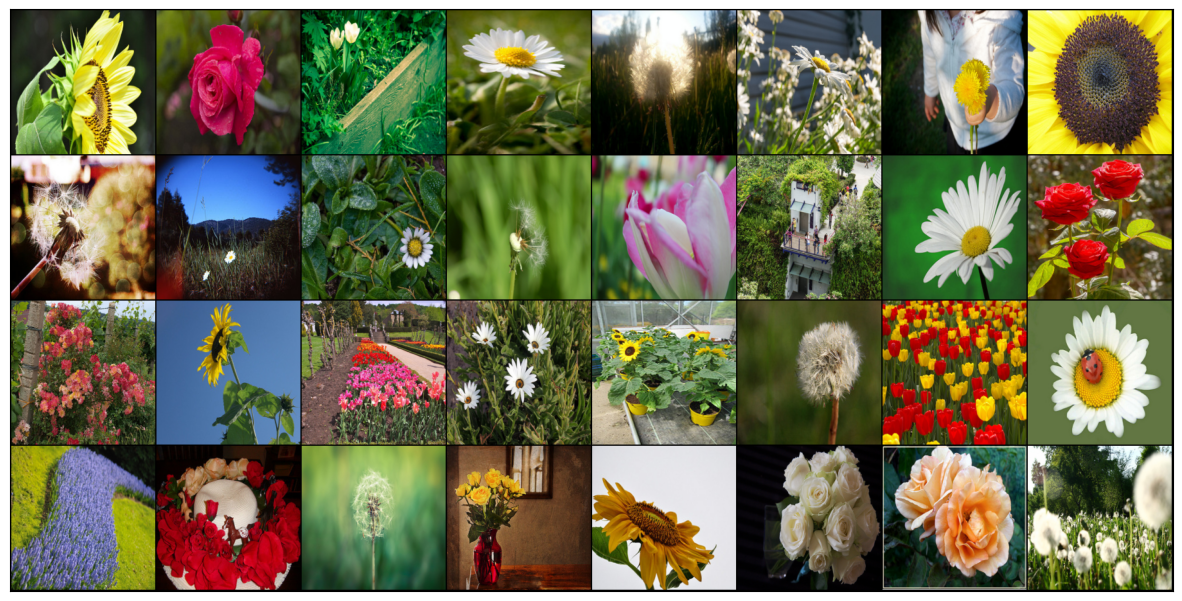

In [15]:
show_batch(train_loader)

torch.Size([128, 3, 224, 224])


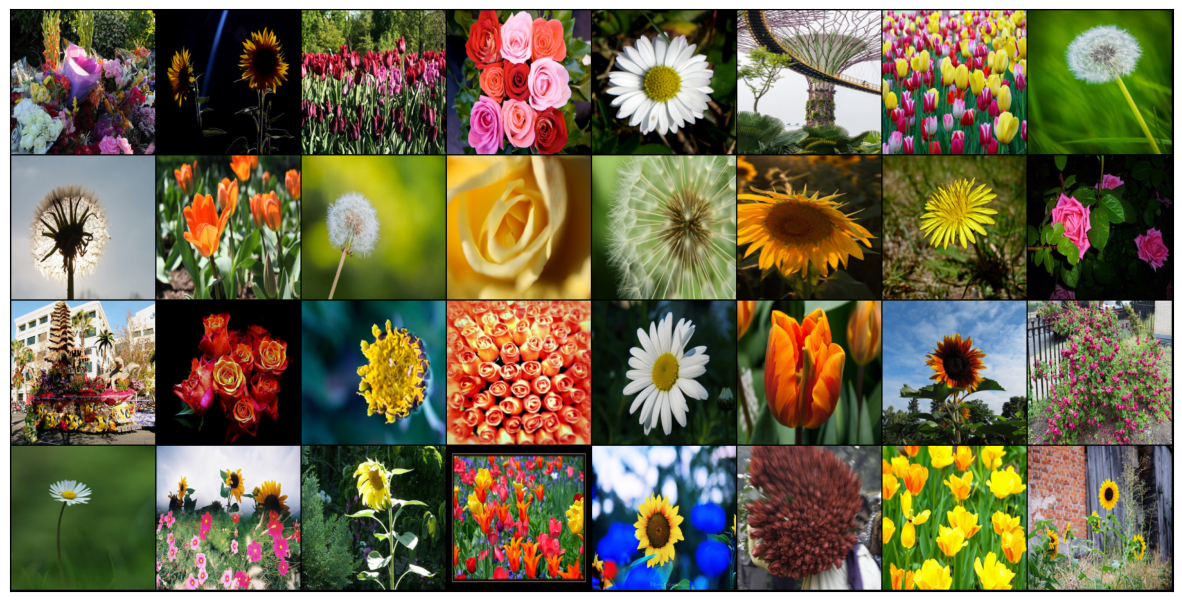

In [16]:
show_batch(test_loader)

In [17]:
import torchvision.models as models
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 74.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
! pip install torchinfo

In [19]:
from torchinfo import summary
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [20]:
model.classifier[1] = nn.Linear(1280, 5)

In [21]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 5]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [22]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [23]:
!pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.3 MB/s eta 0:00:00


In [24]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [25]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [26]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=5)}

In [27]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [28]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [29]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [30]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [31]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [32]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [33]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [34]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 95.36 Сред. ошибка: 0.13340
Результат валидации - Эпоха: 1  Сред. точность: 88.83 Сред. ошибка: 0.41500


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 97.68 Сред. ошибка: 0.07835
Результат валидации - Эпоха: 2  Сред. точность: 90.66 Сред. ошибка: 0.37380


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 99.32 Сред. ошибка: 0.02186
Результат валидации - Эпоха: 3  Сред. точность: 90.66 Сред. ошибка: 0.33332


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 99.73 Сред. ошибка: 0.01088
Результат валидации - Эпоха: 4  Сред. точность: 93.41 Сред. ошибка: 0.26743


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 99.86 Сред. ошибка: 0.00566
Результат валидации - Эпоха: 5  Сред. точность: 92.67 Сред. ошибка: 0.28421


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 99.14 Сред. ошибка: 0.02328
Результат валидации - Эпоха: 6  Сред. точность: 90.66 Сред. ошибка: 0.34830


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.59 Сред. ошибка: 0.05430
Результат валидации - Эпоха: 7  Сред. точность: 89.19 Сред. ошибка: 0.38216


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.23 Сред. ошибка: 0.02469
Результат валидации - Эпоха: 8  Сред. точность: 91.21 Сред. ошибка: 0.33765


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.23 Сред. ошибка: 0.02672
Результат валидации - Эпоха: 9  Сред. точность: 90.11 Сред. ошибка: 0.43017


  6%|5         | 1/18 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 95.91 Сред. ошибка: 0.17441
Результат валидации - Эпоха: 10  Сред. точность: 88.46 Сред. ошибка: 0.65519


State:
	iteration: 180
	epoch: 10
	epoch_length: 18
	max_epochs: 10
	output: 0.5151703953742981
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

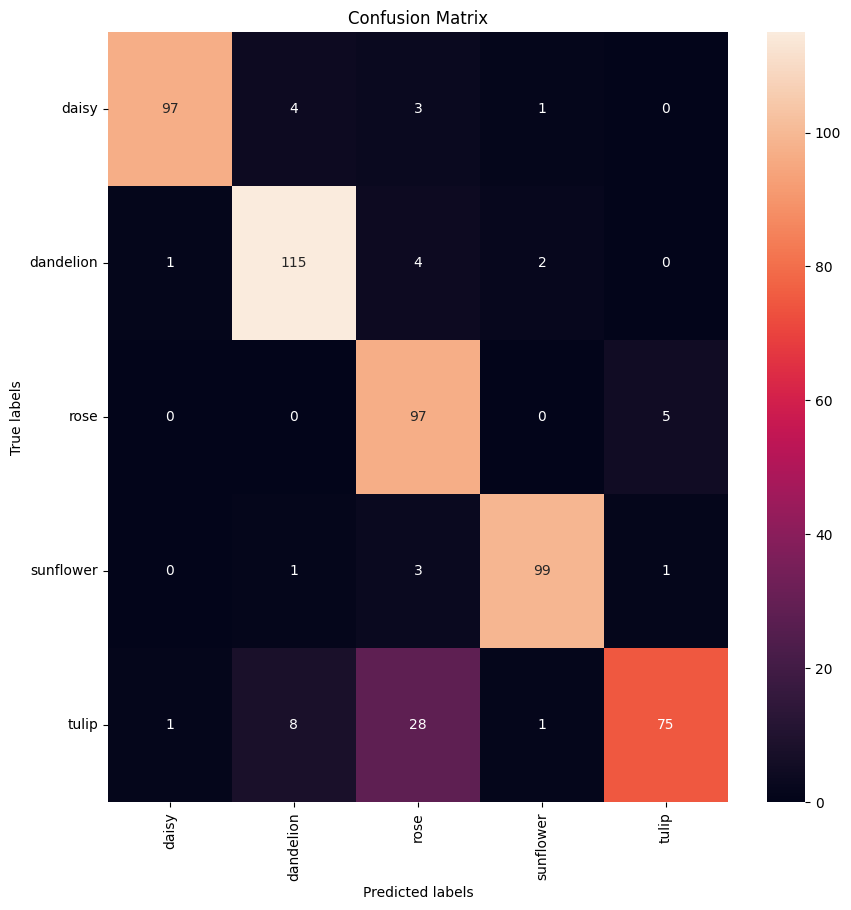

In [35]:
trainer.run(train_loader, max_epochs=6)

## Как мы видим 10 эпох это слишком много и началось переобучение ☹

### В целом модель показала себя неплохо, учитывая, что в наборе попадались картинки очень странные, где я сам цветка не мог найти

In [36]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


<ipython-input-36-02be131d5380>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))


In [37]:
def get_preds(model, loader, device):
  model.eval()
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)

  with torch.no_grad():
      for data in test_loader:
          inputs = [i.to(device) for i in data[:-1]]
          labels = data[-1].to(device)

          outputs = model(*inputs)
          y_true = torch.cat((y_true, labels), 0)
          all_outputs = torch.cat((all_outputs, outputs), 0)

      y_true = y_true.cpu().numpy()
      _, y_pred = torch.max(all_outputs, 1)
      y_pred = y_pred.cpu().numpy()
      y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()

  return y_true, y_pred, y_pred_prob

In [38]:
y_true, y_pred, _ = get_preds(model, test_loader, device)

In [39]:
from sklearn.metrics import matthews_corrcoef, classification_report

In [40]:
print(classification_report(y_true, y_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

       daisy       0.98      0.93      0.96       105
   dandelion       0.92      0.99      0.96       122
        rose       0.90      0.90      0.90       102
   sunflower       0.96      0.96      0.96       104
       tulip       0.91      0.88      0.89       113

    accuracy                           0.93       546
   macro avg       0.94      0.93      0.93       546
weighted avg       0.93      0.93      0.93       546



In [41]:
matthews_corrcoef(y_true,y_pred)

0.917680787150422